In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os, json

%matplotlib inline

In [2]:
import pyusct
from pyusct.preprocess import load_usctsim_result, draw_input

In [3]:
from scipy import signal

In [101]:
from mpl_toolkits.mplot3d import Axes3D

## parameters

In [4]:
result_path = "/mnt/nas/2018-01-12_2/"

#### load parameters as json

In [5]:
param_path = os.path.join(result_path, 'param.json')
with open(param_path, 'r') as f: param = json.load(f)
print(json.dumps(param, indent=4))

{
    "ringarray": {
        "num_points": 256, 
        "radius": 0.05
    }, 
    "source": {
        "point_map": [
            1, 
            2, 
            3, 
            4, 
            5, 
            6, 
            7, 
            8, 
            9, 
            10, 
            11, 
            12, 
            13, 
            14, 
            15, 
            16, 
            17, 
            18, 
            19, 
            20, 
            21, 
            22, 
            23, 
            24, 
            25, 
            26, 
            27, 
            28, 
            29, 
            30, 
            31, 
            32, 
            33, 
            34, 
            35, 
            36, 
            37, 
            38, 
            39, 
            40, 
            41, 
            42, 
            43, 
            44, 
            45, 
            46, 
            47, 
            48, 
            49, 
            50, 
            51, 
            52, 
      

#### load simulation I/O data

In [6]:
param, arr_cart_pos, mask_points, map_speed, map_dens, rfdata = load_usctsim_result(result_path)

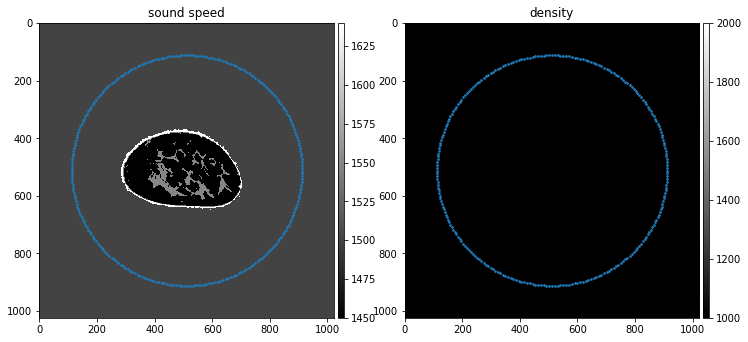

In [48]:
draw_input(mask_points, map_speed, map_dens)

In [8]:
rfdata.data.shape

(256, 256, 4374)

 The shape of the mat rfdata.data is (#source, #sensor, #sampling).

## Time-series preprocessing

In [9]:
rfdata.data -= np.mean(rfdata.data[:,:,0]) # substracting offset pressure

In [10]:
# envelope detection (time consuming ...)
rfdata.data = abs(signal.hilbert(rfdata.data, axis=2))

## Subset extraction regarding target point

#### Example target point (the center of the ring)

In [11]:
target = [0.0, 0.0]

In [17]:
map_time_pos, subset = rfdata.getPointSubset(target, np.arange(-100, 100, 10))
# map_time_pos, subset = rfdata.getPointSubset(target)

In [18]:
subset.shape

(256, 256, 20)

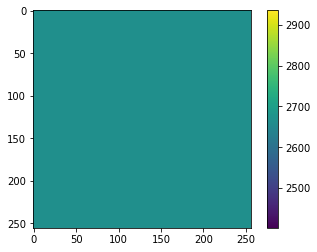

In [19]:
plt.imshow(map_time_pos, interpolation='nearest')
plt.colorbar()

(-0.001, 0.001)

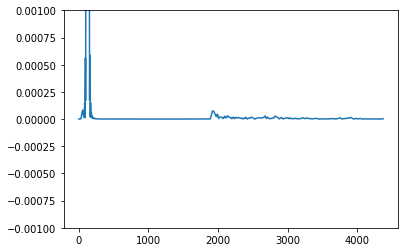

In [20]:
plt.plot(rfdata.data[2,0,:])
plt.ylim(-0.001, 0.001)

2669


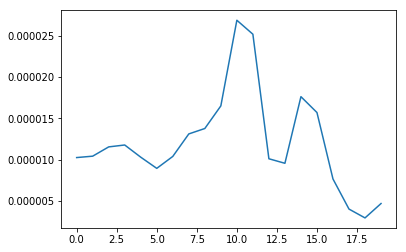

In [21]:
print map_time_pos[2,0]
plt.plot(subset[2,0,:])
#plt.ylim(-0.001, 0.001)

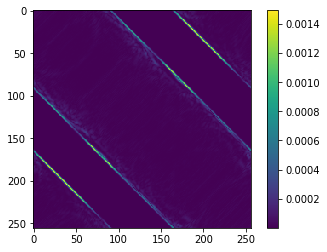

In [23]:
plt.imshow(subset[:,:,10])
plt.colorbar()

#### Another example regarding different point

3904


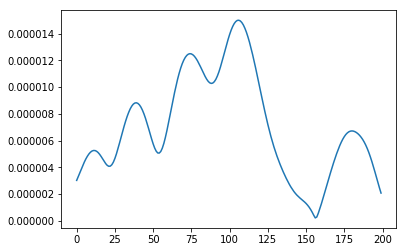

In [24]:
target = [0.02, 0.02]
map_time_pos, subset = rfdata.getPointSubset(target, np.arange(-100, 100, 1))
print map_time_pos[2,0]
plt.plot(subset[2,0,:])

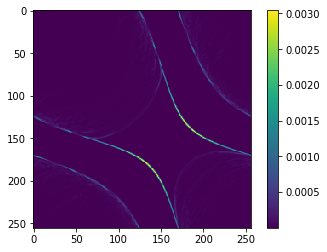

In [25]:
plt.imshow(subset[:,:,100])
plt.colorbar()

In [66]:
subset.shape

(256, 256, 200)

In [ ]:
X, T = np.meshgrid(np.arange(subset.shape[1]), np.arange(subset.shape[2]))
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, T, subset[192, :, :].T)

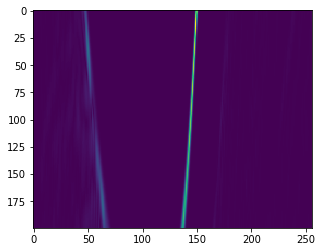

In [93]:
plt.imshow(subset[192, :, :].T)

## Synthetic aperture

In [43]:
c = 4 # compression rate

out_image = np.zeros((param["grid"]["Ny"]/c, param["grid"]["Nx"]/c))

for iy in range(0, param["grid"]["Ny"], c):
    print '.',
    for ix in range(0, param["grid"]["Nx"], c):
        y = (iy - param["grid"]["Ny"]/2) * param["grid"]["dy"]
        x = (ix - param["grid"]["Nx"]/2) * param["grid"]["dx"]
        
        _, submat = rfdata.getPointSubset([y, x]) # no time range
        out_image[iy/c, ix/c] = np.sum(submat[:,:,0]) # summation of envelope

. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


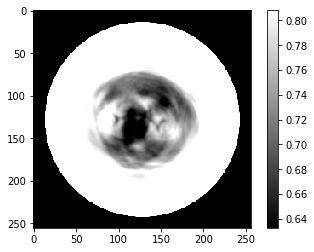

In [53]:
plt.imshow(np.log(out_image).T, interpolation='nearest', cmap='gray', 
           vmax = np.log(np.max(out_image[96:160, 96:160]) ),
           vmin = np.log(np.min(out_image[96:160, 96:160])*1.1 )
          )
plt.colorbar()

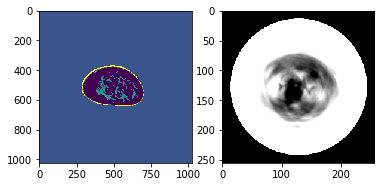

In [58]:
plt.subplot(121)
plt.imshow(np.array(map_speed))

plt.subplot(122)
plt.imshow((out_image).T, interpolation='nearest', cmap='gray', 
           vmax = (np.max(out_image[96:160, 96:160]) ),
           vmin = (np.min(out_image[96:160, 96:160])*1.1 )
          )